In [416]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

%matplotlib inline

import pandahouse as ph

plt.rcParams['figure.figsize'] = (20, 12)

## Задание №1. A/B–тестирование.
В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

In [417]:
import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials

path_to_credential = 'nodal-unity-403717-2e10b091dfb9.json'

scope = ['https://spreadsheets.google.com/feeds',
        'https://www.googleapis.com/auth/drive']

my_mail = 'testname@nodal-unity-403717.iam.gserviceaccount.com'

credentials = ServiceAccountCredentials.from_json_keyfile_name(path_to_credential, scope)

def read_df_active_studs():
    table_name_1 = 'Проект_2_active_studs'
    gs = gspread.authorize(credentials)
    work_sheet_1 = gs.open(table_name_1)
    sheet1 = work_sheet_1.sheet1
    data_1 = sheet1.get_all_values()
    headers_1 = data_1.pop(0)
    df_active_studs = pd.DataFrame(data_1, columns=headers_1)
    return df_active_studs
    
def read_df_checks():
    table_name_1 = 'Проект_2_checks'
    gs = gspread.authorize(credentials)
    work_sheet_1 = gs.open(table_name_2)
    sheet1 = work_sheet_1.sheet1
    data_1 = sheet1.get_all_values()
    headers_1 = data_1.pop(0)
    df_checks = pd.DataFrame(data_1, columns=headers_1)
    return df_checks
    
def read_df_groups():
    table_name_1 = 'Проект_2_groups'
    gs = gspread.authorize(credentials)
    work_sheet_1 = gs.open(table_name_1)
    sheet1 = work_sheet_1.sheet1
    data_1 = sheet1.get_all_values()
    headers_1 = data_1.pop(0)
    df_groups = pd.DataFrame(data_1, columns=headers_1)
    return df_groups
    
def read_df_group_add():
    table_name_1 = 'Проект_2_group_add'
    gs = gspread.authorize(credentials)
    work_sheet_1 = gs.open(table_name_1)
    sheet1 = work_sheet_1.sheet1
    data_1 = sheet1.get_all_values()
    headers_1 = data_1.pop(0)
    df_group_add = pd.DataFrame(data_1, columns=headers_1)
    return df_group_add

df_active_studs = read_df_active_studs()
df_checks = read_df_checks()
df_groups = read_df_groups()
df_group_add = read_df_group_add()

In [418]:
# файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
df_groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [419]:
df_groups.shape

(74484, 2)

Проверим данные на дубликаты

In [420]:
df_groups.duplicated().sum()

0

Проверим данные на ошибку включения одного пользователя в две группы

In [421]:
df_groups.id.duplicated().sum() 

0

Проверим данные на пропуски

In [422]:
df_groups.isna().sum() 

id     0
grp    0
dtype: int64

In [423]:
# дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
df_group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [424]:
df_group_add.shape

(92, 2)

Проверим данные на дубликаты

In [425]:
df_group_add.duplicated().sum() 

0

Проверим данные на ошибку включения одного пользователя в две группы

In [426]:
df_group_add.id.duplicated().sum() 

0

Проверим данные на пропуски

In [427]:
df_group_add.isna().sum()

id     0
grp    0
dtype: int64

Соединим обе таблицы с пользователями в одну

In [428]:
df_groups_all = pd.concat([df_groups, df_group_add])

Проверим, что в соединенной таблице не появилось дубликатов

In [429]:
df_groups_all.duplicated().sum()

0

Проверим, что в соединенных таблицах не было одинаковых пользователей в разных группах

In [430]:
df_groups_all.id.duplicated().sum() 

0

In [431]:
# файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента
df_active_studs

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369
...,...
8336,1794344
8337,296883
8338,3598448
8339,3610547


Проверим на дубликаты

In [348]:
df_active_studs.duplicated().sum()

0

Проверим на пропуски

In [349]:
df_active_studs.isna().sum()

student_id    0
dtype: int64

Для удобства переименуем колонку с пользователями в идентичное название с другими таблицами

In [350]:
df_active_studs.columns = ['id']

Введем значение активности этих пользователей и обозначим единицей

In [351]:
df_active_studs['active'] = 1 

In [352]:
df_active_studs

,id,active
0,581585,1
1,5723133,1
2,3276743,1
3,4238589,1
4,4475369,1
...,...,...
8336,1794344,1
8337,296883,1
8338,3598448,1
8339,3610547,1


Объединим таблицу со всеми участниками групп с таблицей активных пользователей и заменим значение у неактивных пользователей на 0

In [353]:
df_groups_all = df_groups_all.merge(df_active_studs, how = 'left', on = 'id').fillna(0)

In [354]:
df_groups_all.head()

,id,grp,active
0,1489,B,0.0
1,1627,A,1.0
2,1768,B,0.0
3,1783,B,0.0
4,1794,A,0.0


In [355]:
df_checks # файл с информацией об оплатах пользователей в дни проведения эксперимента

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


In [356]:
df_checks.columns = ['id', 'rev']
df_checks['paying'] = 1

Проведем аналогичные проверки данных, как для предыдущих таблиц

In [357]:
df_checks.duplicated().sum()

0

In [358]:
df_checks.id.duplicated().sum()

0

In [359]:
df_checks.isna().sum()

id        0
rev       0
paying    0
dtype: int64

Объединим основную таблицу с нашими пользователями с таблицей об облатах, для пользователей без оплаты ставим 0

In [360]:
df = df_groups_all.merge(df_checks, how = 'left', on = 'id').fillna(0)

In [361]:
df

,id,grp,active,rev,paying
0,1489,B,0.0,0,0.0
1,1627,A,1.0,990.0,1.0
2,1768,B,0.0,0,0.0
3,1783,B,0.0,0,0.0
4,1794,A,0.0,0,0.0
...,...,...,...,...,...
74571,200247820,B,0.0,0,0.0
74572,201032527,B,0.0,0,0.0
74573,201067612,B,0.0,0,0.0
74574,201067653,B,0.0,0,0.0


In [362]:
df.dtypes

id         object
grp        object
active    float64
rev        object
paying    float64
dtype: object

In [363]:
df.rev = pd.to_numeric(df.rev)

Проверим есть ли пользователи которые были не активны в период проведения А/В теста, но от них были оплаты

In [364]:
df.query('active == 0 and rev > 0')

,id,grp,active,rev,paying
39,3185,B,0.0,690.0,1.0
121,25973,B,0.0,690.0,1.0
125,26280,B,0.0,690.0,1.0
223,100645,B,0.0,630.0,1.0
254,102534,B,0.0,580.0,1.0
...,...,...,...,...,...
72452,5291900,B,0.0,199.0,1.0
72753,5331842,B,0.0,290.0,1.0
73632,5486319,B,0.0,199.0,1.0
74049,5562806,B,0.0,398.0,1.0


Выявлено 149 оплат, при которых пользователь не был активен.
Возможно данная особенность является ошибкой в данных, но возможно это фича с автоматической оплатой.

Изучим наши группы А и В

In [365]:
results = df.groupby('grp').agg({'active' : 'sum', 'id' : 'nunique', 'rev' : 'sum'})
results.columns = ['count_active_users', 'count_all_users', 'profit']
results

,count_active_users,count_all_users,profit
grp,,,
A,1538.0,14693,92096.0000
B,6803.0,59883,481230.0036


Замечаем, что изначально в тестовой группе значительно большее количество пользователей.
Так же в тестовой группе значительно больше активных пользователей и общей выручки.

Но мы знаем, что не каждый активный пользователь - клиент. Добавим в исследуемые метрики количество клиентов.

In [366]:
results['count_active_paying_users'] = df.query("active == 1 and rev > 0").groupby('grp').agg({'rev' : 'count'})
results['count_paying_users'] = df.query('rev > 0').groupby('grp').agg({'rev' : 'count'})
results

,count_active_users,count_all_users,profit,count_active_paying_users,count_paying_users
grp,,,,,
A,1538.0,14693,92096.0000,78,107
B,6803.0,59883,481230.0036,314,434


Видим, что количество покупающих пользователей в тестовой группе так же выше.
Выделим несколько метрик, которые и будем исследовать:
* Конверсия активных пользователей в покупку
* ARPPU (активных клиентов, чтобы не учитывать тех кто настроил автоплатеж)
* Средний чек активных клиентов

Данные метрики выбраны из расчета того, что нас интересует как вели себя активные пользователи, так как не активные не видели измененной механики оплаты. 

In [367]:
results['CR_active'] = round(100*results.count_active_paying_users / results.count_active_users,2)
results['ARPPU'] = results.profit / results.count_active_paying_users
results['mean_check_active_users'] = df.query('active == 1').groupby('grp').agg({'rev' : 'mean'}) 
results

,count_active_users,count_all_users,profit,count_active_paying_users,count_paying_users,CR_active,ARPPU,mean_check_active_users
grp,,,,,,,,
A,1538.0,14693,92096.0000,78,107,5.07,1180.717949,47.347204
B,6803.0,59883,481230.0036,314,434,4.62,1532.579629,58.058798


Text(0.5, 1.0, 'Средний чек активных пользователей')

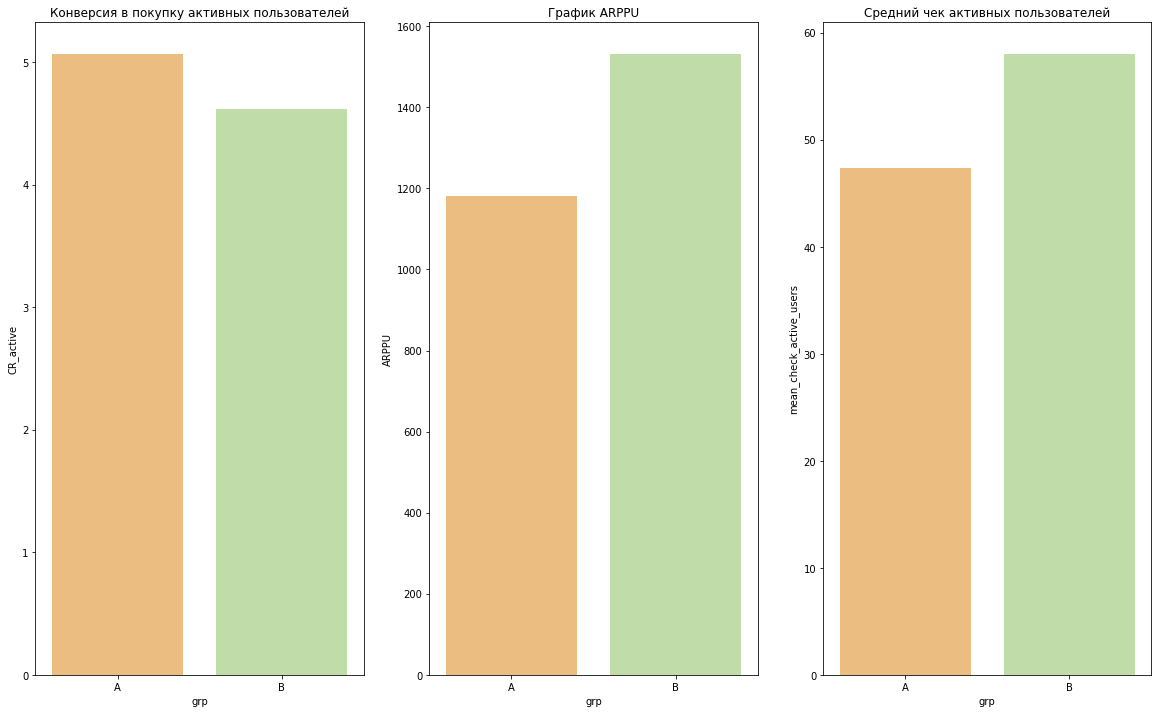

In [368]:
plt.subplot(1, 3, 2)
sns.barplot(data = results.reset_index(), x = 'grp', y = 'ARPPU', palette='Spectral')
plt.title('График ARPPU')

plt.subplot(1, 3, 1)
sns.barplot(data = results.reset_index(), x = 'grp', y = 'CR_active', palette='Spectral')
plt.title('Конверсия в покупку активных пользователей')

plt.subplot(1, 3, 3)
sns.barplot(data = results.reset_index(), x = 'grp', y = 'mean_check_active_users', palette='Spectral')
plt.title('Средний чек активных пользователей')

ARPPU и средний чек клиентов ожидаемо больше в тестовой группе, а вот конверсия в покупку активных пользователей напротив больше у контрольной группы. Проверим визуальные предположения с помощью статистических методов.

### Изучим первую метрику: CR активных пользователей в покупку

In [369]:
df_active_paying = results[['count_active_paying_users', 'count_active_users']]
df_active_paying['count_active_not_paying'] = df_active_paying.count_active_users - df_active_paying.count_active_paying_users
df_active_paying = df_active_paying[['count_active_paying_users', 'count_active_not_paying']]
df_active_paying

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,count_active_paying_users,count_active_not_paying
grp,,
A,78,1460.0
B,314,6489.0


Text(0.5, 1.0, 'Количество активных клиентов')

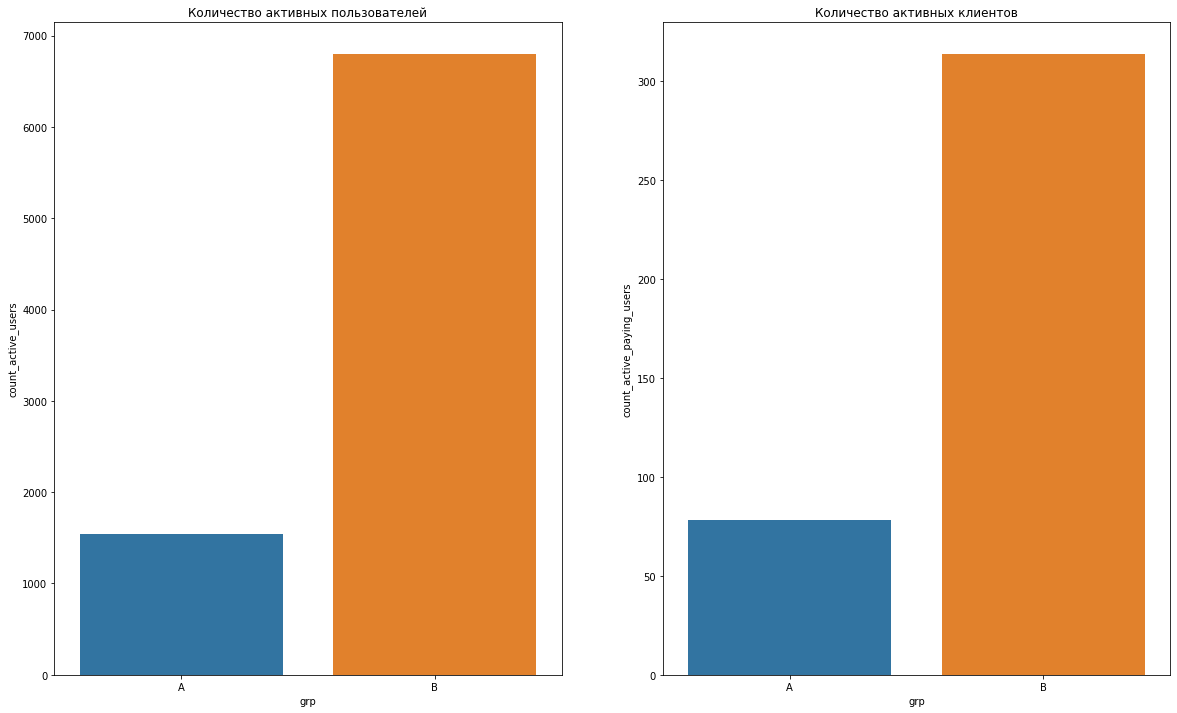

In [370]:
plt.subplot(1, 2, 1)
sns.barplot(data = results[['count_active_paying_users', 'count_active_users']].reset_index(), x = 'grp', y = 'count_active_users')
plt.title('Количество активных пользователей')

plt.subplot(1, 2, 2)
sns.barplot(data = results[['count_active_paying_users', 'count_active_users']].reset_index(), x = 'grp', y = 'count_active_paying_users')
plt.title('Количество активных клиентов')

Изучим конверсию активных пользователей в покупку.

**Сформулируем Н0:** Конверсия в покупку активных пользователей в обеих группах одинакова

In [371]:
diff_CR = []
rev_A = df.query("grp == 'A' and active ==1").paying
rev_B = df.query("grp == 'B' and active == 1").paying

for i in range(10000):
    sample_A = rev_A.sample(frac=1, replace=True)
    sample_CR_A = sample_A.sum()/len(rev_A)
    
    sample_B = rev_B.sample(frac=1, replace=True)
    sample_CR_B = sample_B.sum()/len(rev_B)

    diff = sample_CR_A - sample_CR_B
    diff_CR.append(diff)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


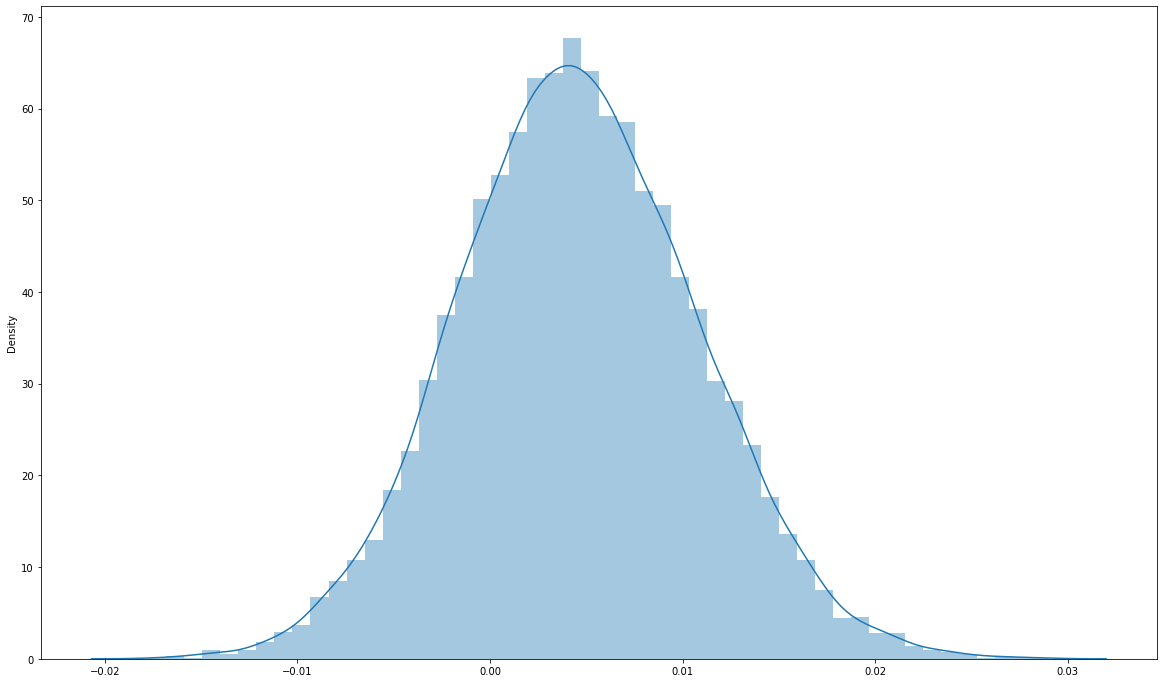

In [372]:
sns.distplot(diff_CR)

In [373]:
left = pd.Series(diff_CR).quantile(0.025)
right = pd.Series(diff_CR).quantile(0.975)
if 0 > left and 0 < right:
    print('0 входит в доверительный интервал.\nНе можем отклонить H0')
else:
    print('0 не входит в доверительный интервал.\nМожем отклонить H0')

0 входит в доверительный интервал.
Не можем отклонить H0


По результатам проведенного анализа **не имеем возможности отклонить Н0**, что снова подтверждает наше первоначальное предположение о **равенстве конверсии активных пользователей в покупку** в обеих группах.

### Изучим вторую метрику: ARPPU

In [374]:
results['ARPPU']

grp
A    1180.717949
B    1532.579629
Name: ARPPU, dtype: float64

ARPPU есть средняя прибыль на каждого клиента.

**Сформулируем Н0:** ARPPU в наших группах одинакова.

In [375]:
diff_means_2 = []
rev_A = df.query("grp == 'A' and active ==1 and rev > 0").rev
rev_B = df.query("grp == 'B' and active == 1 and rev > 0").rev

for i in range(10000):
    sample_A = rev_A.sample(frac=1, replace=True)
    sample_means_A = sample_A.mean()
    
    sample_B = rev_B.sample(frac=1, replace=True)
    sample_means_B = sample_B.mean()

    diff = sample_means_A - sample_means_B
    diff_means_2.append(diff)

Построим получившиеся распределение разностей средних

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


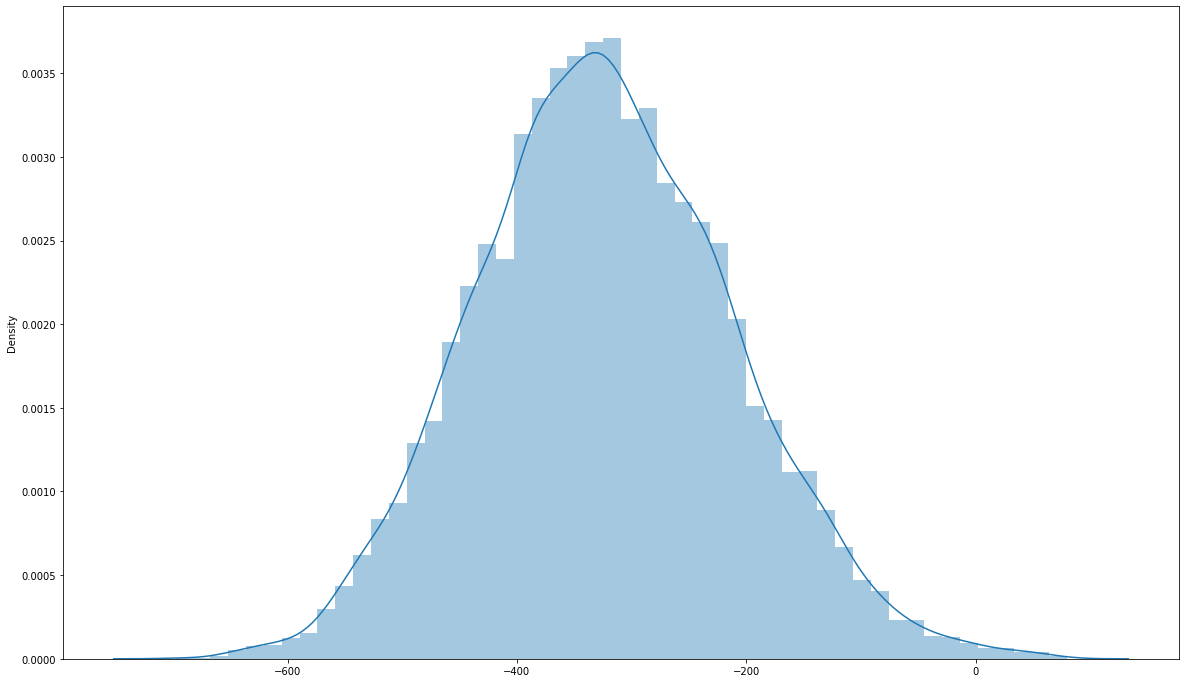

In [376]:
sns.distplot(diff_means_2)

In [377]:
left = pd.Series(diff_means_2).quantile(0.025)
right = pd.Series(diff_means_2).quantile(0.975)
if 0 > left and 0 < right:
    print('0 входит в доверительный интервал.\nНе можем отклонить H0')
else:
    print('0 не входит в доверительный интервал.\nМожем отклонить H0')

0 не входит в доверительный интервал.
Можем отклонить H0


Построив распределение разностей средних по прибыли в группах и посчитав доверительный интервал - получили результат, согласно которому **можем отклонить нулевую гипотезу** и утверждать, что **в тестовой группе ARPPU стат.значимо больше, чем в контрольной.**

### Изучим третью метрику: средний чек для активных клиентов

In [378]:
results['mean_check_active_users']

grp
A    47.347204
B    58.058798
Name: mean_check_active_users, dtype: float64

**Сформлируем H0:** Средний чек у активных пользователей в группах не отличется  

In [379]:
diff_means_check = []
active_profit_A = df.query("grp == 'A' and active == 1").rev
active_profit_B = df.query("grp == 'B' and active == 1").rev

for i in range(10000):
    sample_A = active_profit_A.sample(frac=1, replace=True)
    sample_means_A = sample_A.mean()
    
    sample_B = active_profit_B.sample(frac=1, replace=True)
    sample_means_B = sample_B.mean()

    diff = sample_means_A - sample_means_B
    diff_means_check.append(diff)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


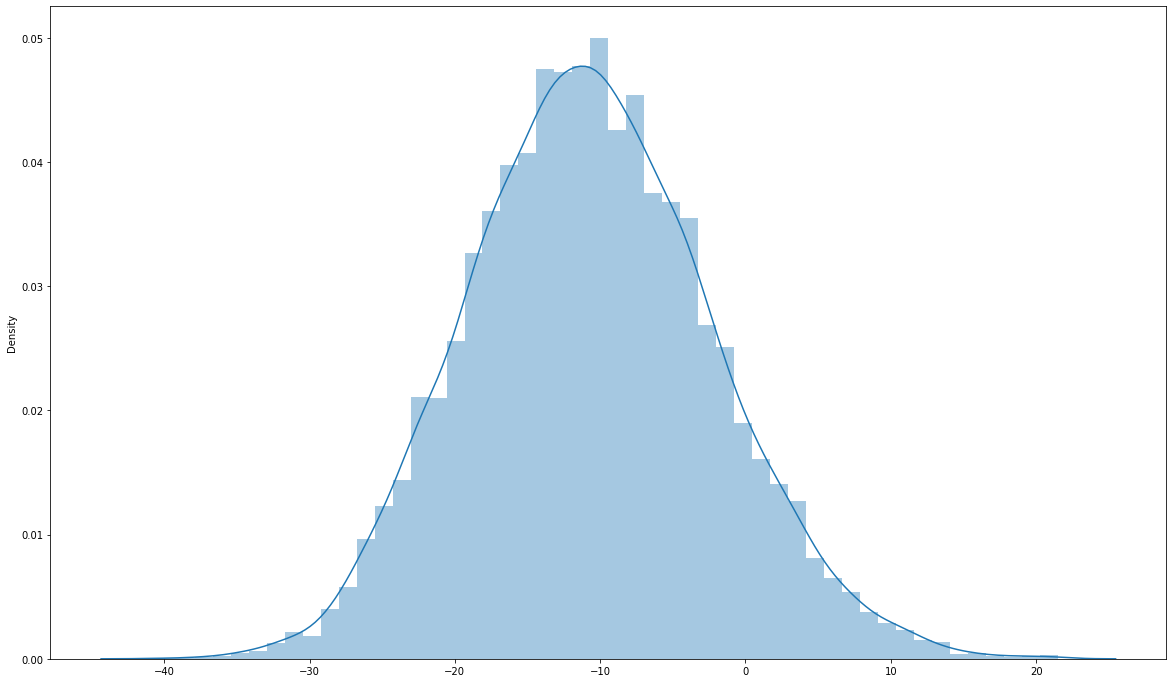

In [380]:
sns.distplot(diff_means_check)

In [381]:
left = pd.Series(diff_means_check).quantile(0.025)
right = pd.Series(diff_means_check).quantile(0.975)
if 0 > left and 0 < right:
    print('0 входит в доверительный интервал.\nНе можем отклонить H0')
else:
    print('0 не входит в доверительный интервал.\nМожем отклонить H0')

0 входит в доверительный интервал.
Не можем отклонить H0


Получили результат который не дает нам возможность **отклонить нулевую гипотезу** и утверждать, что **в тестовой группе средний чек активных пользователей стат.значимо выше чем в контрольной.**

### Вывод
Получили следующие результаты исследований:
* **CR активных в покупку** - одинаковый у двух групп
* **ARPPU** - отличается стат.значимо в группах
* **Средний чек активных пользователей** - одинаковый у двух групп

Делаем вывод, что в тестовой группе значимо увеличилась средняя прибыль на каждого активного клиента (ARPPU).
Значение конверсии активных пользователей в покупку и средний чек активных пользователей в группах равны.
Кроме того, не можем не отметить отсутствие в изученных метриках падений значений для тестовой группы.

Из всего вышеперечисленного можем сделать вывод о **целесообразности развертывания новой механики на всех пользователей.** Но стоит следить за вышеуказанными метриками, особенно касающихся прибыли, так как мы изучали достаточно неравные группы.

# Задание 2

## Задание 2.1

Объявляем параметры подключения

In [217]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

Выведем всех студентов которые верно решили >=20 "Горошин" и количество верных решенных "Горошин" за крайний месяц сохраненный в базе данных

In [218]:
query = """ 
WITH Max_date AS (SELECT MAX(timest) as max_date FROM peas)

SELECT st_id, SUM(correct) as sum_correct FROM peas
WHERE YEAR(timest) == (SELECT YEAR(max_date) FROM Max_date)
and MONTH(timest) == (SELECT MONTH(max_date) FROM Max_date)
GROUP BY st_id
HAVING SUM(correct) >= 20
"""
df = ph.read_clickhouse(query, connection=connection)
df

,st_id,sum_correct
0,700123,126
1,171209,26
2,219630,53
3,416918,26
4,877738,22
...,...,...
131,375731,24
132,71465,38
133,936163,29
134,790532,22


Выведем количество таких студентов 
(Вывести данное количество мы могли бы сразу из базы данные с помощью SQL, но для наглядности сделали именно так)

In [219]:
df.st_id.count()

136

## Задача 2.2

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:
* ARPU 
* ARPAU 
* CR в покупку 
* СR активного пользователя в покупку 
* CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [220]:
query = """ 
WITH table as (SELECT * 
               FROM studs
               LEFT JOIN final_project_check
               ON studs.st_id = final_project_check.st_id), 

    ARPU as (SELECT test_grp, 
                    round(sum(money)/count(DISTINCT st_id),2) as ARPU 
             FROM table 
             GROUP BY test_grp),

    ARPAU as (SELECT test_grp, 
                     round(sum(money)/(SELECT count(DISTINCT st_id) 
                                       FROM table 
                                       WHERE money > 0)
                           ,2) as ARPAU 
              FROM table 
              GROUP BY test_grp), 

    CR_to_buy as (SELECT test_grp, 
                         round(100*count(DISTINCT st_id) / (SELECT count(DISTINCT st_id) 
                                                            FROM table)
                               ,2) as CR_to_buy
                  FROM table 
                  WHERE money > 0 
                  GROUP BY test_grp), 

    CR_active_to_buy as (SELECT test_grp, 
                                round(100 * count(DISTINCT st_id) / (SELECT count(st_id) 
                                                                     FROM (SELECT st_id 
                                                                           FROM peas
                                                                           GROUP BY st_id
                                                                           HAVING sum(correct) > 10))
                                      ,2) as CR_active_to_buy
                        FROM table
                        WHERE st_id IN (SELECT st_id 
                                        FROM peas
                                        GROUP BY st_id
                                        HAVING sum(correct) > 10) 
                          and money > 0
                        GROUP BY test_grp),  

    CR_active_math_to_buy as (SELECT test_grp, 
                                     round(100*count(DISTINCT st_id) / (SELECT count(st_id) 
                                                                        FROM (SELECT st_id 
                                                                              FROM peas
                                                                              WHERE subject = 'Math'
                                                                              GROUP BY st_id
                                                                              HAVING sum(correct) >= 2)
                                           ),2) as CR_active_math_to_buy
                              FROM table
                              WHERE subject = 'Math' and 
                                    money > 0 and 
                                    st_id IN (SELECT st_id 
                                              FROM peas
                                              WHERE subject = 'Math'  
                                              GROUP BY st_id
                                              HAVING sum(correct) >= 2)  
                              GROUP BY test_grp) 



SELECT ARPU.test_grp as test_grp,
       ARPU,
       ARPAU,
       CR_to_buy,
       CR_active_to_buy,
       CR_active_math_to_buy
FROM ARPU
INNER JOIN ARPAU
ON ARPU.test_grp = ARPAU.test_grp 
INNER JOIN CR_to_buy
ON ARPU.test_grp = CR_to_buy.test_grp 
INNER JOIN CR_active_to_buy
ON ARPU.test_grp = CR_active_to_buy.test_grp 
INNER JOIN CR_active_math_to_buy
ON ARPU.test_grp = CR_active_math_to_buy.test_grp 
"""
df = ph.read_clickhouse(query, connection=connection)
df

,test_grp,ARPU,ARPAU,CR_to_buy,CR_active_to_buy,CR_active_math_to_buy
0,control,4540.98,29468.09,2.50,6.28,3.3
1,pilot,11508.47,72234.04,5.33,11.21,4.4


# Задание 3

## Задание 3.1
Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [407]:
def update_metric():
    df_active_studs = read_df_active_studs()
    df_checks = read_df_checks()
    df_groups = read_df_groups()
    df_group_add = read_df_group_add()
    
    df_active_studs.columns = ['id']
    df_active_studs['active'] = 1 
    df_checks.columns = ['id', 'rev']
    df_groups_all = df_groups.merge(df_active_studs, how = 'left', on = 'id')\
                             .merge(df_checks, how = 'left', on = 'id')\
                             .fillna(0)
    
    
    df = pd.concat([df_groups_all, df_group_add])
    
    df.rev = pd.to_numeric(df.rev)
    
    update_results = df.groupby('grp').agg({'active' : 'sum', 'id' : 'nunique', 'rev' : 'sum'})
    update_results.columns = ['count_active_users', 'count_all_users', 'profit']
    update_results['count_active_paying_users'] = df.query("active == 1 and rev > 0").groupby('grp').agg({'rev' : 'count'})
    update_results['count_paying_users'] = df.query('rev > 0').groupby('grp').agg({'rev' : 'count'})
    update_results['CR_active'] = round(100*results.count_active_paying_users / results.count_active_users,2)
    update_results['ARPPU'] = results.profit / results.count_paying_users
    update_results['mean_check_active_users'] = df.query('active == 1 and rev > 0').groupby('grp').agg({'rev' : 'mean'}) 
    
    return update_results


In [415]:
update_results = update_metric()
update_results

,count_active_users,count_all_users,profit,count_active_paying_users,count_paying_users,CR_active,ARPPU,mean_check_active_users
grp,,,,,,,,
A,1535.0,14693,92096.0000,78,107,5.08,860.710280,933.589744
B,6793.0,59883,479330.0036,313,433,4.61,1106.997699,1255.827487


## Задание 3.2
Реализуйте функцию, которая будет строить графики по получаемым метрикам

In [413]:
def update_graph(update_results):

    plt.subplot(1, 3, 2)
    sns.barplot(data = results.reset_index(), x = 'grp', y = 'ARPPU', palette='Spectral')
    plt.title('График ARPPU')

    plt.subplot(1, 3, 1)
    sns.barplot(data = results.reset_index(), x = 'grp', y = 'CR_active', palette='Spectral')
    plt.title('Конверсия в покупку активных пользователей')

    plt.subplot(1, 3, 3)
    sns.barplot(data = results.reset_index(), x = 'grp', y = 'mean_check_active_users', palette='Spectral')
    plt.title('Средний чек активных пользователей')

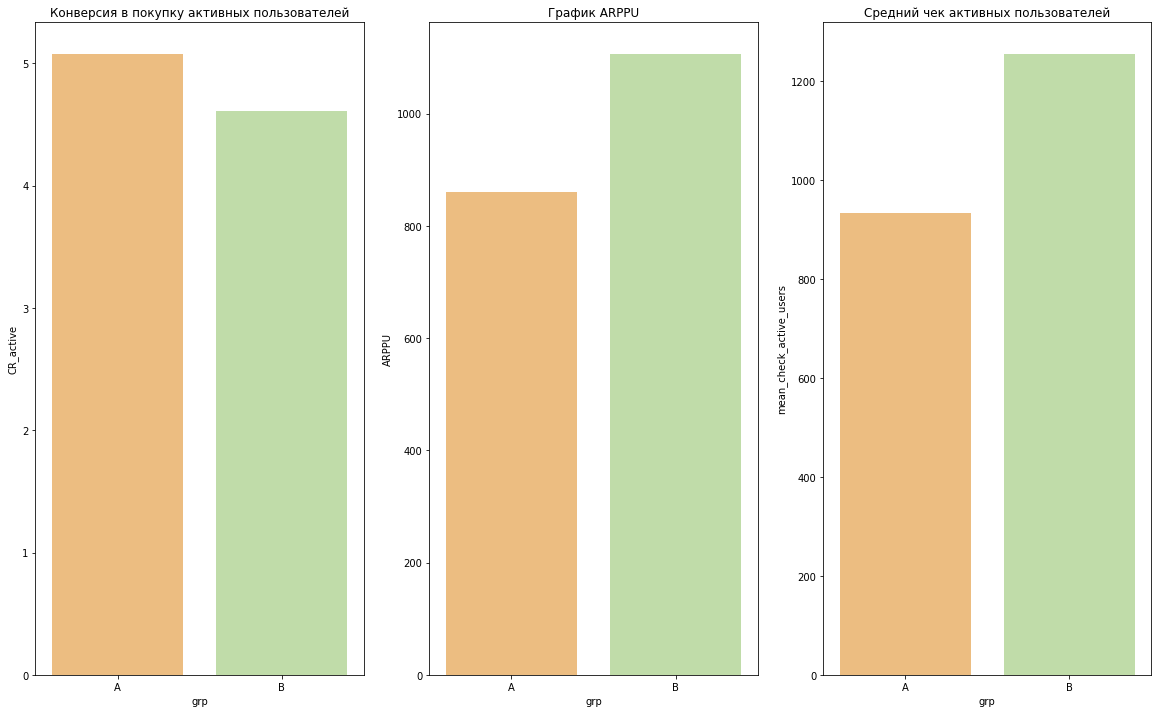

In [414]:
# Для построения графиков по измененным метрикам вызываем функцию 'update_graph' от посчитанной таблицы с метриками 'results'
update_graph(update_results)